In [ ]:
pip install transformers

In [ ]:
pip install ekphrasis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import numpy as np
import torch
import functools
import operator
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer, RobertaForSequenceClassification, RobertaTokenizer, DistilBertForSequenceClassification, DistilBertTokenizer, AlbertForSequenceClassification, AlbertTokenizer, ElectraForSequenceClassification, ElectraTokenizer, get_linear_schedule_with_warmup
from transformers import BartForSequenceClassification, BartTokenizer, XLNetForSequenceClassification, XLNetTokenizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from collections import defaultdict, Counter
from tqdm import tqdm, trange
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Set up Helper Functions

In [ ]:
def clean_text(data, normalize_list, annotate_list):
        """
        This function preprocesses the text using the Ekphrasis library
        
        data: Pandas series object containing strings of text

        normalize_list: list of data features to clean

        annotate_list: list of data features to annotate
        """

        text_processor = TextPreProcessor(
            normalize= normalize_list,
            annotate= annotate_list,
            fix_html=True,
            segmenter="twitter", 
            unpack_hashtags=True,  
            unpack_contractions=True,  
            spell_correct_elong=True,  
            tokenizer=SocialTokenizer(lowercase=True).tokenize,
            dicts=[emoticons]
        )

        clean_data = data.map(lambda x: " ".join(text_processor.pre_process_doc(x)))

        return clean_data


def early_stopping(val_loss_values, early_stop_vals):
    """
    Determines whether or not the model will keep running based on the patience and delta given relative to the val loss
    """
    if len(val_loss_values) > early_stop_vals["patience"]:
      if val_loss_values[-1] <= np.mean(np.array(val_loss_values[-1-early_stop_vals["patience"]:-1])) - early_stop_vals["delta"]:
        return False
      else:
        return True
    else:
      return False


def training_plot(train_loss_values, val_loss_values):
    """
    Plots loss after each epoch

    training_loss_values: list of floats; output from fine_tune function

    val_loss_values: list of floats; output from fine_tune function
    """
    sns.set(style='darkgrid')
    plt.rcParams["figure.figsize"] = (12,6)

    plt.plot(train_loss_values, 'b-o', label="train")
    plt.plot(val_loss_values, 'g-o', label="valid")

    #plt.title("Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    #plt.savefig("dogwhistle_train_plot.png",bbox_inches='tight')

    return plt.show()


def metrics(labels, preds, argmax_needed: bool = False):
    """
    Returns the Matthew's correlation coefficient, accuracy rate, true positive rate, true negative rate, false positive rate, false negative rate, precission, recall, and f1 score
    
    labels: list of correct labels

    pred: list of model predictions
    """
    labels = labels
    preds = preds

    if argmax_needed == True:
        preds = np.argmax(preds, axis=1).flatten()

    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    f1 = f1_score(labels, preds, average= "weighted")
    precision = precision_score(labels, preds, average= "weighted")
    recall = recall_score(labels, preds, average= "weighted")

    results = {
        "mcc": mcc,
        "acc": acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    
    return results, labels, preds


def confusion_matrix_plotter(results, save_name, x_tick_labels, y_tick_labels, color):
    """
    Plots confusion matrix

    results: dictionary item containing key of confusion matrix (output of sklearn confusion_matrix())

    x_tick_labels: list of tick labels on x axis

    y_tick_labels: list of tick labels on y axis

    save_name: name of image to be produced with .png

    color: color selection from matplotlib cmap choices: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    """

    df_cm = pd.DataFrame(results.ravel()[0]["confusion_matrix"])

    fig = plt.figure(figsize=(16, 12))
    
    plt.rc('axes', labelsize=14)  
    plt.rc('xtick', labelsize=12)   
    plt.rc('ytick', labelsize=12)       

    #plt.subplot(2, 2, 1)
    g1 = sns.heatmap(df_cm, annot=True, fmt='g', cmap=color)
    g1.set_xlabel('Predicted Label')
    g1.set_ylabel('True Label', rotation=0) 
    g1.xaxis.set_ticklabels(x_tick_labels, rotation=0) 
    g1.yaxis.set_ticklabels(y_tick_labels, rotation=0) 

    plt.show()

    return fig.savefig(save_name,bbox_inches='tight')


def combine_text(df):
    """
    Combines tweet and image text into one column

    df: Dataframe which holds the data
    """
    combined_text = []

    for row_num in range(len(df)):
        tweet_text = df.loc[row_num, "tweet_text"]
        image_text = df.loc[row_num, "img_text"]
        if type(image_text) == str:
            combined_text.append(tweet_text + image_text)
        else:
            combined_text.append(tweet_text)

    return combined_text


### Load Data

In [ ]:
#Load data for pretraining
# df = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/labeled_data.csv", encoding='utf-8')
# train, _, dev = stratify(df, "hate_speech", [0.9, 0.1])

In [ ]:
train = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Train/dog_whistle_train.csv", encoding='utf-8')
dev = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Validation/dog_whistle_dev.csv", encoding='utf-8')
test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')

In [ ]:
train["combined_text"] = combine_text(train)
dev["combined_text"] = combine_text(dev)
test["combined_text"] = combine_text(test)

In [ ]:
#train = train[["image_number", "combined_text", "Unimodal_text_numeric", "Primary_numeric_gt"]]
#dev = dev[["image_number", "combined_text", "Unimodal_text_numeric", "Primary_numeric_gt"]] 
#test = test[["image_number", "combined_text", "Unimodal_text_numeric", "Primary_numeric_gt"]] 

In [ ]:
# from sklearn.utils import shuffle
# train = shuffle(train)

### Inspect Text Length

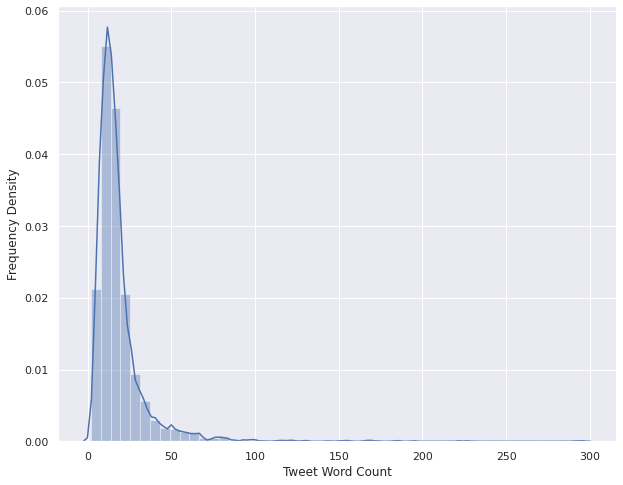

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

tweet_lens = []

for i in train["combined_text"]:
  tokens = i.split()
  tweet_lens.append(len(tokens))

#visualize word count distributions
fig = plt.figure(figsize=(10, 8))
g1 = sns.distplot(tweet_lens)

g1.set_xlabel('Tweet Word Count')
g1.set_ylabel('Frequency Density')

fig.savefig('tweet_length_distribution.png',bbox_inches='tight')

In [ ]:
train["lengths"] = tweet_lens

a = train[train["lengths"] > 100]
len(a)

25

### Run Model

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, model, num_labels: int, pad_length: int= 64, batch_size: int = 32):
        """
        model: From HuggingFace transformers library

        num_labels (int): Number of annotation classes

        pad_length (int): Max sentence length. Defaulted to 64.

        batch_size (int): Number of sentences in batch. Default is 32.
        """
        super(TransformerClassifier, self).__init__()
        self.model_types = {
          "AlBERT": [AlbertForSequenceClassification, AlbertTokenizer, 'albert-xxlarge-v2'],  # 'albert-xlarge-v2' "albert-large-v2" 'albert-base-v2' 'albert-xxlarge-v2'
          "BART": [BartForSequenceClassification, BartTokenizer, "bart-large"], 
          "BERT": [BertForSequenceClassification, BertTokenizer, 'bert-large-uncased'], #'bert-base-uncased'
          "DistilBERT": [DistilBertForSequenceClassification, DistilBertTokenizer, 'distilbert-base-cased'], #'/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/DistilBERT'],# 'distilbert-base-cased'], #
          "Electra": [ElectraForSequenceClassification, ElectraTokenizer, "google/electra-large-discriminator"], #"google/electra-small-discriminator"
          "RoBERTa": [RobertaForSequenceClassification, RobertaTokenizer, 'roberta-large'], #'roberta-base'
          "XLNet": [XLNetForSequenceClassification, XLNetTokenizer, "xlnet-large-cased"], #"xlnet-base-cased"
          } 
        self.model_selection = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model_types[self.model_selection][0].from_pretrained(self.model_types[self.model_selection][2], num_labels = num_labels).to(self.device)
        self.seed_val = 22
        self.pad_length = pad_length
        self.batch_size = batch_size

        #random.seed(self.seed_val)
        np.random.seed(self.seed_val)
        torch.manual_seed(self.seed_val)
        if self.device == 'cuda':
            torch.cuda.manual_seed_all(self.seed_val)

    def preprocessor(self, sequence, labels):
        """
        This function converts a string of text into a tokenized format compatible with the selected model

        sequence: An iterable series of data (i.e. Pandas Series, list..) where elements are strings

        labels: Pandas series containing data annotations
        """
        
        self.tokenizer = self.model_types[self.model_selection][1].from_pretrained(self.model_types[self.model_selection][2])

        indexed_tokens = []
        attention_masks = []


        for counter, sentence in enumerate(sequence):
            if counter % 1000 == 0:
                print("Processing row {}".format(counter))
            if counter == len(sequence):
                print("Done!")

            encoded_dict = self.tokenizer.encode_plus(
                      sentence,            
                      add_special_tokens = True,
                      max_length = self.pad_length,         
                      pad_to_max_length = True,
                      return_attention_mask = True,  
                      return_tensors = 'pt',   
                  )
  
            indexed_tokens.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        return self.batcher(torch.cat(indexed_tokens, dim=0), torch.cat(attention_masks, dim=0), labels)


    def batcher(self, indexed_tokens, attention_masks, labels):
        """
        This function creates batches of a specified size to save on memory

        indexed_tokens: Tokenized text output by model preprocesser

        attention_masks: Attention masks output by model preprocesser

        labels: Pandas series containing data annotations
        """

        data = TensorDataset(indexed_tokens, attention_masks, labels)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size = self.batch_size)

        return dataloader


    def fine_tune(self, train_data, train_labels, dev_data, dev_labels, normalize_list, annotate_list, early_stop_vals: dict, epochs: int = 3, learning_rate: float = 2e-5, weight_decay: float = 0.1, warmup: float = 0.06):   
        """
        Updates pre-trained model's weights based on given dataset

        train_data: Pandas series object containing text data for train set

        train_labels: Pandas series object containing ground truth annotations for train set

        dev_data: Pandas series object containing text data for dev set

        dev_labels: Pandas series object containing ground truth annotations for dev set

        normalize_list: list of data features to clean

        annotate_list: list of data features to annotate

        early_stopping: Dictionary containing patience value (int) and delta value (float). The patience determines the number of epochs to wait to achieve the given delta

        epochs (int): Number of times to run through all batches. Default value is 3 according to 2-4 recommended in original BERT paper.

        learning_rate (float): Default value is 2e-5 according to recommended value from original BERT paper.

        weight decay (float): Default value is 0.1 

        warmup (float): Default value is 0.06; percentage of training steps in warmup
        """
    
        #self.train_labels = torch.Tensor(train_labels.values).to(torch.int64)
        #self.dev_labels = torch.Tensor(dev_labels.values).to(torch.int64)
        
        #clean_train_data = clean_text(train_data, normalize_list, annotate_list)
        #clean_val_data = clean_text(dev_data, normalize_list, annotate_list)
        self.train_dataloader = self.preprocessor(clean_text(train_data, normalize_list, annotate_list), torch.Tensor(train_labels.values).to(torch.int64))
        self.val_dataloader = self.preprocessor(clean_text(dev_data, normalize_list, annotate_list), torch.Tensor(dev_labels.values).to(torch.int64))

        self.optimizer = optim.AdamW(self.model.parameters(), lr = learning_rate, weight_decay = weight_decay)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps = warmup * (len(self.train_dataloader) * epochs), num_training_steps = (1-warmup) * (len(self.train_dataloader) * epochs))

        train_loss_values, val_loss_values, train_acc_values, val_acc_values = [], [], [], []

        for epoch in trange(epochs, desc= "Epoch"):
            if early_stopping(val_loss_values, early_stop_vals) == False:
                print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
                print('Training...')

                train_total_loss, train_total_len, train_num_correct = 0, 0, 0

                self.model.train()

                for step, batch in enumerate(self.train_dataloader):
                    if step % 50 == 0:
                        print("Processing batch...{}".format(step))
                        print("  Batch {:>5,}  of  {:>5,}.".format(step, len(self.train_dataloader)))

                    train_total_len += batch[0].shape[0]
                    b_input_ids, b_input_mask, b_labels = tuple(t.to(self.device) for t in batch)

                    self.model.zero_grad()  

                    outputs = self.model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels.unsqueeze(0))

                    train_total_loss += outputs[0].item()
                    outputs[0].backward()

                    pred = outputs[1].argmax(1, keepdim=True).float()
                    correct_tensor = pred.eq(b_labels.float().view_as(pred))
                    correct = np.squeeze(correct_tensor.cpu().numpy())
                    train_num_correct += np.sum(correct)

                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    self.optimizer.step()
                    self.scheduler.step()

                train_acc = train_num_correct / train_total_len
                train_acc_values.append(train_acc)
                avg_train_loss = train_total_loss / len(self.train_dataloader)            
                train_loss_values.append(avg_train_loss)

                print()
                print("Running Validation...")
                print()

                val_total_loss, val_total_len, num_correct = 0, 0, 0 

                self.model.eval()

                for batch in self.val_dataloader:
                    val_total_len += batch[0].shape[0]
                    b_input_ids, b_input_mask, b_labels = tuple(t.to(self.device) for t in batch)

                    with torch.no_grad():        

                        outputs = self.model(b_input_ids, attention_mask=b_input_mask, labels=b_labels.unsqueeze(0)) #Are labels needed?
  
                    val_total_loss += outputs[0].item()

                    pred = outputs[1].argmax(1, keepdim=True).float()
                    correct_tensor = pred.eq(b_labels.float().view_as(pred))
                    correct = np.squeeze(correct_tensor.cpu().numpy())
                    num_correct += np.sum(correct)

                val_acc = num_correct / val_total_len
                val_acc_values.append(val_acc)
                avg_val_loss = val_total_loss / len(self.val_dataloader)  
                val_loss_values.append(avg_val_loss)

                #print(f"Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss")
                print("Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss")
                print(f"{epoch+1:3d} |    {train_acc:.3f}    |       {val_acc:.3f}       |    {avg_train_loss:.3f}    |     {avg_val_loss:.3f}")
                print()

                if epoch == (epochs-1):
                    training_plot(train_loss_values, val_loss_values)
                    training_dict = {"Train Accuracy": train_acc_values, "Train Loss": train_loss_values, "Val Accuracy": val_acc_values, "Val Loss": val_loss_values}
                    print("Training complete!")
                    return training_dict#, self.tokenizer
                else:
                    continue
      
            else:
                print("Stopping early...")
                training_plot(train_loss_values, val_loss_values)
                training_dict = {"Train Accuracy": train_acc_values, "Train Loss": train_loss_values, "Val Accuracy": val_acc_values, "Val Loss": val_loss_values}
                print("Training complete!")
                return training_dict#, self.tokenizer


    def test(self, test_data, test_labels, normalize_list, annotate_list):
        """
        Tests the model's performance based on a several metrics

        test_data: Pandas series object containing text data

        test_labels: Pandas series object containing labels

        normalize_list: list of data features to clean

        annotate_list: list of data features to annotate
        """
        self.test_labels = torch.Tensor(test_labels.values).to(torch.int64)

        clean_test_data = clean_text(test_data, normalize_list, annotate_list)
        self.test_dataloader = self.preprocessor(clean_test_data, self.test_labels)
    
        print('Predicting labels for {} sentences...'.format(len(self.test_labels)))

        self.model.eval()

        predictions, true_labels = [], []

        for batch in self.test_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(self.device) for t in batch)
      
            with torch.no_grad():
                outputs = self.model(b_input_ids, attention_mask=b_input_mask)

            logits = outputs[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

        print('    DONE.')

        predictions = functools.reduce(operator.iconcat, predictions, [])
        true_labels = functools.reduce(operator.iconcat, true_labels, [])
    
        return metrics(true_labels, predictions, argmax_needed= True)


    def save(self, output_directory, training_dict, labels, preds, results):
        """
        Saves PyTorch Model and other outputs
        
        output_directory: Directory to folder to save file in

        training_dict: Dictionary of training and validation values 

        labels: List of labels for test set

        preds: List of model predictions after passed through argmax()

        results: Dictionary of metrics

        tokenizer: Tokenizer to be saved. Defaulted to None.
        """

        output_directory = os.path.join(output_directory, self.model_selection)
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
        
        os.chdir(output_directory)

        np.save(self.model_selection+"_dogwhistle_train_results.npy", training_dict) #save training dict
        np.save(self.model_selection+"_dogwhistle_test_results.npy", results) #save test metrics
        
        test_predictions = pd.DataFrame([labels, preds]) #save predictions and labels 
        test_predictions = test_predictions.T
        test_predictions = test_predictions.rename(columns={0: 'Labels', 1: 'Predictions'})
        test_predictions.to_csv(self.model_selection+"_dogwhistle_predictions.csv")

        #save models
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model 
        model_to_save.save_pretrained(output_directory) 
        self.tokenizer.save_pretrained(output_directory)

        return print("Saving complete.")

In [ ]:
#RoBERTa fine-tuning hyperparameters for GLUE: 
NORMALIZE_LIST = ['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number']
ANNOTATE_LIST = ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored']
LEARNING_RATE = [1e-5, 2e-5, 3e-5]
N_EPOCHS = 10 
EARLY_STOPPING = {"patience": 2, "delta": 0.005} 
N_LABELS =  4
PAD_LENGTH = 100 #250
BATCH_SIZE = [16, 32, 64]
WEIGHT_DECAY = 0.1 
WARMUP = 0.06 
OUTPUT_DIR = "/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text"

### Model Running

In [ ]:
#.52 gb before this cell is run
#this cell adds 1.18 gigs
# clean_train_data = clean_text(train["combined_text"], NORMALIZE_LIST, ANNOTATE_LIST)
# clean_val_data = clean_text(dev["combined_text"], NORMALIZE_LIST, ANNOTATE_LIST)

In [ ]:
#this cell adds .63
# clean_train_data2 = clean_text(train["combined_text"], ["url", "hashtag", "user"], [])
# clean_val_data2 = clean_text(dev["combined_text"], ["url", "hashtag", "user"], [])

In [ ]:
# #Pretrain models
#Classifier = TransformerClassifier("DistilBERT", N_LABELS, PAD_LENGTH, 16) 
#train_dict, tokenizer = Classifier.fine_tune(train["tweet"], train["hate_speech"], dev["tweet"], dev["hate_speech"], NORMALIZE_LIST, ANNOTATE_LIST, EARLY_STOPPING, N_EPOCHS, 1e-5, WEIGHT_DECAY, WARMUP) 
#results, labels, preds = Classifier.test(test["combined_text"], test["Primary_numeric_gt"], NORMALIZE_LIST, ANNOTATE_LIST)
#Classifier.save(OUTPUT_DIR, train_dict, [], [], {})

Saving complete.



Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt



Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Processing row 0
======== Epoch 1 / 10 ========
Training...
Processing batch...0
  Batch     0  of    250.
Processing batch...50
  Batch    50  of    250.
Processing batch...100
  Batch   100  of    250.
Processing batch...150
  Batch   150  of    250.
Processing batch...200
  Batch   200  of    250.

Running Validation...



Epoch:  10%|█         | 1/10 [13:35<2:02:20, 815.65s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  1 |    0.572    |       0.700       |    0.958    |     0.837

======== Epoch 2 / 10 ========
Training...
Processing batch...0
  Batch     0  of    250.
Processing batch...50
  Batch    50  of    250.
Processing batch...100
  Batch   100  of    250.
Processing batch...150
  Batch   150  of    250.
Processing batch...200
  Batch   200  of    250.

Running Validation...



Epoch:  20%|██        | 2/10 [27:10<1:48:44, 815.54s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  2 |    0.739    |       0.638       |    0.742    |     0.871

======== Epoch 3 / 10 ========
Training...
Processing batch...0
  Batch     0  of    250.
Processing batch...50
  Batch    50  of    250.
Processing batch...100
  Batch   100  of    250.
Processing batch...150
  Batch   150  of    250.
Processing batch...200
  Batch   200  of    250.

Running Validation...



Epoch:  30%|███       | 3/10 [40:46<1:35:08, 815.46s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  3 |    0.782    |       0.738       |    0.653    |     0.764

======== Epoch 4 / 10 ========
Training...
Processing batch...0
  Batch     0  of    250.
Processing batch...50
  Batch    50  of    250.
Processing batch...100
  Batch   100  of    250.
Processing batch...150
  Batch   150  of    250.
Processing batch...200
  Batch   200  of    250.

Running Validation...



Epoch:  40%|████      | 4/10 [54:21<1:21:32, 815.41s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  4 |    0.817    |       0.740       |    0.546    |     0.801

======== Epoch 5 / 10 ========
Training...
Processing batch...0
  Batch     0  of    250.
Processing batch...50
  Batch    50  of    250.
Processing batch...100
  Batch   100  of    250.
Processing batch...150
  Batch   150  of    250.
Processing batch...200
  Batch   200  of    250.

Running Validation...



Epoch:  50%|█████     | 5/10 [1:07:56<1:07:56, 815.36s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  5 |    0.866    |       0.750       |    0.400    |     0.915

Stopping early...


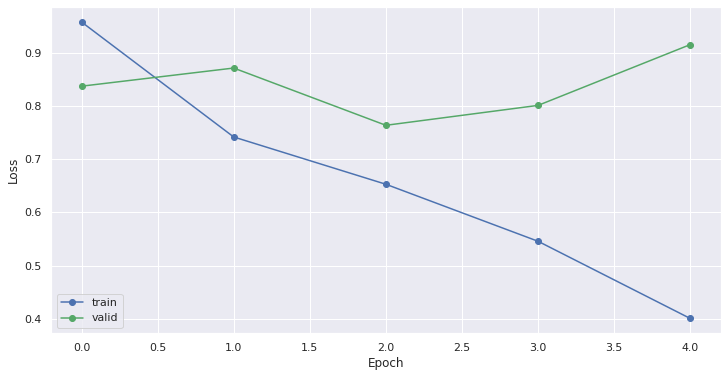

Training complete!
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Processing row 0
Predicting labels for 502 sentences...
    DONE.
{'mcc': 0.5571325148053428, 'acc': 0.750996015936255, 'confusion_matrix': array([[221,  27,   0,  20],
       [ 46, 137,   0,   2],
       [  9,   3,   0,   0],
       [ 15,   3,   0,  19]]), 'precision': 0.7365880932383312, 'recall': 0.7424728090920185, 'f1': 0.7424728090920185}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Practice run
Classifier = TransformerClassifier("AlBERT", N_LABELS, PAD_LENGTH, 16) 
train_dict = Classifier.fine_tune(train["combined_text"], train["Unimodal_text_numeric"], dev["combined_text"], dev["Unimodal_text_numeric"], NORMALIZE_LIST, ANNOTATE_LIST, EARLY_STOPPING, N_EPOCHS, 1e-5, WEIGHT_DECAY, WARMUP) 
results, labels, preds = Classifier.test(test["combined_text"], test["Primary_numeric_gt"], NORMALIZE_LIST, ANNOTATE_LIST)
#Classifier.save(OUTPUT_DIR, train_dict, labels, preds, results)
print(results)

In [ ]:
results_dict = {}
max_f1_value = 0

for i in BATCH_SIZE:
    learning_rate_dict = {}
    for j in LEARNING_RATE: 
        Classifier = TransformerClassifier("DistilBERT", N_LABELS, PAD_LENGTH, i) 
        train_dict, tokenizer = Classifier.fine_tune(train["combined_text"], train["Unimodal_text_numeric"], dev["combined_text"], dev["Unimodal_text_numeric"], NORMALIZE_LIST, ANNOTATE_LIST, EARLY_STOPPING, N_EPOCHS, j, WEIGHT_DECAY, WARMUP) 
        learning_rate_dict[j], labels, preds = Classifier.test(test["combined_text"], test["Primary_numeric_gt"], NORMALIZE_LIST, ANNOTATE_LIST)
        results2, labels2, preds2 = Classifier.test(test["combined_text"], test["Unimodal_text_numeric"], NORMALIZE_LIST, ANNOTATE_LIST)

    if learning_rate_dict[j]["f1"] >= max_f1_value: #only save best model
        max_f1_value = learning_rate_dict[j]["f1"]
        print("The new top F1 score is: {}. Saving model...".format(max_f1_value))
        Classifier.save(OUTPUT_DIR, train_dict, labels, preds, learning_rate_dict[j])
        np.save(os.path.join(os.path.join(OUTPUT_DIR, "DistilBERT"), "dogwhistle_unimodal_label_test_results.npy"), results2)

    results_dict[i] = learning_rate_dict 

#save complete training results
np.save(os.path.join(os.path.join(OUTPUT_DIR, "DistilBERT"), "dogwhistle_total_training_results.npy"), results_dict)

In [ ]:
BEST_LR = 1e-5
BEST_BATCH_SIZE = 16
MODEL_LIST = ["AlBERT", "BERT", "Electra", "RoBERTa"]

model_comparison = {}

for model in MODEL_LIST:
    Classifier = TransformerClassifier(model, N_LABELS, PAD_LENGTH, BEST_BATCH_SIZE) 
    train_dict, tokenizer = Classifier.fine_tune(train["combined_text"], train["Unimodal_text_numeric"], dev["combined_text"], dev["Unimodal_text_numeric"], NORMALIZE_LIST, ANNOTATE_LIST, EARLY_STOPPING, N_EPOCHS, BEST_LR, WEIGHT_DECAY, WARMUP) 
    model_comparison[model], labels, preds = Classifier.test(test["combined_text"], test["Primary_numeric_gt"], NORMALIZE_LIST, ANNOTATE_LIST)

    Classifier.save(OUTPUT_DIR, train_dict, labels, preds, model_comparison[model])

#save complete training results
np.save(os.path.join(os.path.join(OUTPUT_DIR, model), "dogwhistle_total_training_results.npy"), model_comparison)

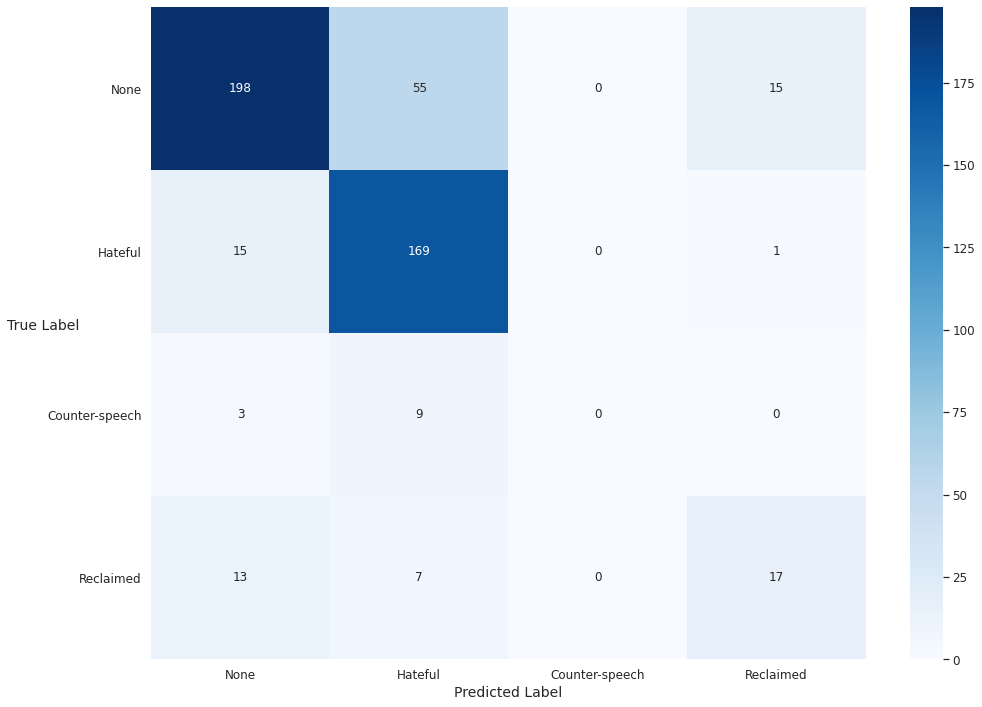

In [ ]:
X_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
Y_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
COLOR = "Blues"
SAVE_NAME = "RoBERTa_cm_dogwhistle.png" #update with best model
BEST_RESULTS_CM = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/RoBERTa/RoBERTa_dogwhistle_test_results.npy", allow_pickle=True)

confusion_matrix_plotter(BEST_RESULTS_CM, SAVE_NAME, X_TICK_LABELS, Y_TICK_LABELS, COLOR)

### Investigating How Dataset Size Effects Performance

In [ ]:
f1_scores = {}

for i in [500, 1000, 1500, 2000, 2500, 3000, 3500]: 
    Classifier = TransformerClassifier("RoBERTa", N_LABELS, PAD_LENGTH, 16) 
    train_dict = Classifier.fine_tune(train["combined_text"][:i], train["Unimodal_text_numeric"][:i], dev["combined_text"], dev["Unimodal_text_numeric"], NORMALIZE_LIST, ANNOTATE_LIST, EARLY_STOPPING, N_EPOCHS, 1e-5, WEIGHT_DECAY, WARMUP) 
    results, labels, preds = Classifier.test(test["combined_text"], test["Primary_numeric_gt"], NORMALIZE_LIST, ANNOTATE_LIST)
    print(results)

    fl_scores[i] = results["f1"]

print(f1_scores)
np.save(os.path.join(OUTPUT_DIR, "RoBERTA/RoBERTA_datasize_results.npy"), f1_scores)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Processing row 0


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

======== Epoch 1 / 10 ========
Training...
Processing batch...0
  Batch     0  of    219.
Processing batch...50
  Batch    50  of    219.
Processing batch...100
  Batch   100  of    219.
Processing batch...150
  Batch   150  of    219.
Processing batch...200
  Batch   200  of    219.

Running Validation...



Epoch:  10%|█         | 1/10 [07:17<1:05:37, 437.46s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  1 |    0.623    |       0.764       |    0.939    |     0.662

======== Epoch 2 / 10 ========
Training...
Processing batch...0
  Batch     0  of    219.
Processing batch...50
  Batch    50  of    219.
Processing batch...100
  Batch   100  of    219.
Processing batch...150
  Batch   150  of    219.
Processing batch...200
  Batch   200  of    219.

Running Validation...



Epoch:  20%|██        | 2/10 [14:34<58:18, 437.27s/it]  

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  2 |    0.765    |       0.784       |    0.642    |     0.636

======== Epoch 3 / 10 ========
Training...
Processing batch...0
  Batch     0  of    219.
Processing batch...50
  Batch    50  of    219.
Processing batch...100
  Batch   100  of    219.
Processing batch...150
  Batch   150  of    219.
Processing batch...200
  Batch   200  of    219.

Running Validation...



Epoch:  30%|███       | 3/10 [21:51<51:00, 437.16s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  3 |    0.804    |       0.766       |    0.543    |     0.631

======== Epoch 4 / 10 ========
Training...
Processing batch...0
  Batch     0  of    219.
Processing batch...50
  Batch    50  of    219.
Processing batch...100
  Batch   100  of    219.
Processing batch...150
  Batch   150  of    219.
Processing batch...200
  Batch   200  of    219.

Running Validation...



Epoch:  40%|████      | 4/10 [29:08<43:42, 437.13s/it]

Epoch | Train Accuracy | Validation Accuracy | Training Loss | Validation Loss
  4 |    0.840    |       0.782       |    0.462    |     0.664

Stopping early...


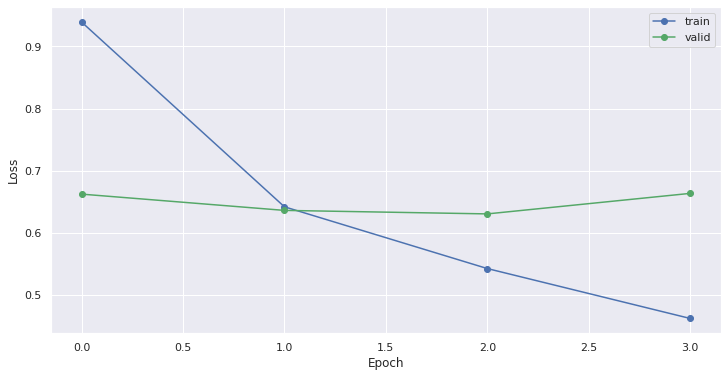

Training complete!
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Processing row 0
Predicting labels for 502 sentences...
    DONE.
{'mcc': 0.5945410935046146, 'acc': 0.7768924302788844, 'confusion_matrix': array([[237,  23,   0,   8],
       [ 42, 142,   0,   1],
       [  6,   5,   0,   1],
       [ 22,   4,   0,  11]]), 'precision': 0.7514949641803342, 'recall': 0.7595830180882215, 'f1': 0.7595830180882215}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Classifier = TransformerClassifier("RoBERTa", N_LABELS, PAD_LENGTH, 16) 
train_dict = Classifier.fine_tune(train["combined_text"][:3500], train["Unimodal_text_numeric"][:3500], dev["combined_text"], dev["Unimodal_text_numeric"], NORMALIZE_LIST, ANNOTATE_LIST, EARLY_STOPPING, N_EPOCHS, 1e-5, WEIGHT_DECAY, WARMUP) 
results, labels, preds = Classifier.test(test["combined_text"], test["Primary_numeric_gt"], NORMALIZE_LIST, ANNOTATE_LIST)
print(results)

In [ ]:
test["Predictions"] = preds
dw_df = test[test["Strategies_numeric_gt"] == 2]

dw_results, _, _ = metrics(dw_df["Primary_numeric_gt"], dw_df["Predictions"])
print(dw_results)

{'mcc': 0.0, 'acc': 0.7815126050420168, 'confusion_matrix': array([[ 0,  0],
       [26, 93]]), 'precision': 1.0, 'recall': 0.8773584905660377, 'f1': 0.8773584905660377}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
explicit_df = test[test["Strategies_numeric_gt"] == 1]

explicit_results, _, _ = metrics(explicit_df["Primary_numeric_gt"], explicit_df["Predictions"])
print(explicit_results)

{'mcc': 0.0, 'acc': 0.7424242424242424, 'confusion_matrix': array([[ 0,  0,  0],
       [16, 49,  1],
       [ 0,  0,  0]]), 'precision': 1.0, 'recall': 0.8521739130434782, 'f1': 0.8521739130434782}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
none_df = test[test["Strategies_numeric_gt"] == 0]

none_results, _, _ = metrics(none_df["Primary_numeric_gt"], none_df["Predictions"])
print(none_results)

{'mcc': 0.24500348864808977, 'acc': 0.7823343848580442, 'confusion_matrix': array([[237,  23,   0,   8],
       [  0,   0,   0,   0],
       [  6,   5,   0,   1],
       [ 22,   4,   0,  11]]), 'precision': 0.8202934349145885, 'recall': 0.7968916734340334, 'f1': 0.7968916734340334}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
